<a href="https://colab.research.google.com/github/deepthivj-aiml/Anomaly-Detection/blob/main/Anomaly_Detection_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.0 MB/s eta 0:00:00
Dataset shape: (50000, 30)
Columns: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Heuristic anomalies: 6896
AE training done.


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:38:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8605
           1       0.99      0.99      0.99      1395

    accuracy                           1.00     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000



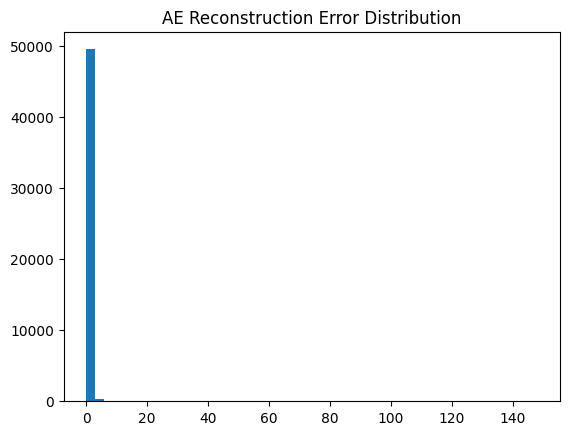

In [8]:
# Single-Cell Colab: Netflix-Style Anomaly Detection with Open Data (Download + Save)
!pip install --quiet scikit-learn xgboost pandas numpy matplotlib seaborn torch

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# -----------------------------
# Step 0: Download Public Dataset (Credit Card Fraud)
# -----------------------------
import os
import urllib.request

url = "https://raw.githubusercontent.com/krishnaik06/creditcardfraud/main/creditcard.csv" # Changed 'master' to 'main'
file_path = "/content/creditcard.csv"
if not os.path.exists(file_path):
    # Re-running this cell might resolve transient network issues that caused the 404 error.
    urllib.request.urlretrieve(url, file_path)
print("Dataset downloaded and saved as", file_path)

# Load dataset
df = pd.read_csv(file_path).sample(50000, random_state=42)  # subset for demo
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# -----------------------------
# Step 1: Heuristic Pseudo-Labels (Domain-Driven)
# -----------------------------
# Example heuristics: large amount, unusual feature combinations
df['heuristic_label'] = ((df['Amount']>200) | (df['V1']<-3)).astype(int)
print("Heuristic anomalies:", df['heuristic_label'].sum())

# -----------------------------
# Step 2: Feature Engineering
# -----------------------------
features = ['Amount','V1','V2','V3','V4','V5','V6']  # numeric features
df_feat = df[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feat)

# -----------------------------
# Step 3: Autoencoder for anomaly scoring
# -----------------------------
class AE(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(n_features,16), nn.ReLU(), nn.Linear(16,8))
        self.decoder = nn.Sequential(nn.Linear(8,16), nn.ReLU(), nn.Linear(16,n_features))
    def forward(self,x): return self.decoder(self.encoder(x))

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
ae = AE(X_scaled.shape[1])
optimizer = torch.optim.Adam(ae.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train Autoencoder (short demo)
for epoch in range(20):
    optimizer.zero_grad()
    loss = criterion(ae(X_tensor), X_tensor)
    loss.backward()
    optimizer.step()
print("AE training done.")

# Compute reconstruction error as anomaly score
with torch.no_grad():
    recon = ae(X_tensor)
    errors = torch.mean((recon - X_tensor)**2, dim=1).numpy()

# -----------------------------
# Step 4: Combine Heuristics + AE score
# -----------------------------
df['ae_score'] = errors
df['label'] = df['heuristic_label']  # pseudo-label for supervised phase
df['ae_score_scaled'] = StandardScaler().fit_transform(df[['ae_score']])

X = np.hstack([X_scaled, df['ae_score_scaled'].values.reshape(-1,1)])
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# -----------------------------
# Step 5: Evaluation
# -----------------------------
print(classification_report(y_test, y_pred))
plt.hist(df['ae_score'], bins=50)
plt.title("AE Reconstruction Error Distribution")
plt.show()